# Long-Horizon Probabilistic Forecasting


Long-horizon forecasting is challenging because of the *volatility* of the predictions and the *computational complexity*. To solve this problem we created the [NHITS](https://arxiv.org/abs/2201.12886) model and made the code available [NeuralForecast library](https://nixtla.github.io/neuralforecast/models.nhits.html). `NHITS` specializes its partial outputs in the different frequencies of the time series through hierarchical interpolation and multi-rate input processing. We model the target time-series with Student's t-distribution. The `NHITS` will output the distribution parameters for each timestamp. 

In this notebook we show how to use `NHITS` on the [ETTm2](https://github.com/zhouhaoyi/ETDataset) benchmark dataset for probabilistic forecasting. This data set includes data points for 2 Electricity Transformers at 2 stations, including load, oil temperature.

We will show you how to load data, train, and perform automatic hyperparameter tuning, **to achieve SoTA performance**, outperforming even the latest Transformer architectures for a fraction of their computational cost (50x faster).

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/LongHorizon_Probabilistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Libraries

In [ ]:
%%capture
!pip install neuralforecast datasetsforecast

## 2. Load ETTm2 Data

The `LongHorizon` class will automatically download the complete ETTm2 dataset and process it.

It return three Dataframes: `Y_df` contains the values for the target variables, `X_df` contains exogenous calendar features and `S_df` contains static features for each time-series (none for ETTm2). For this example we will only use `Y_df`.

If you want to use your own data just replace `Y_df`. Be sure to use a long format and have a simmilar structure than our data set.

In [ ]:
import pandas as pd
from datasetsforecast.long_horizon import LongHorizon

In [ ]:
# Change this to your own data to try the model
Y_df, _, _ = LongHorizon.load(directory='./', group='ETTm2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 960 timestamps as validation and test
n_time = len(Y_df.ds.unique())
val_size = 96*10
test_size = 96*10

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,HUFL,2016-07-01 00:00:00,-0.041413
1,HUFL,2016-07-01 00:15:00,-0.185467
57600,HULL,2016-07-01 00:00:00,0.040104
57601,HULL,2016-07-01 00:15:00,-0.214450
115200,LUFL,2016-07-01 00:00:00,0.695804
115201,LUFL,2016-07-01 00:15:00,0.434685
172800,LULL,2016-07-01 00:00:00,0.434430
172801,LULL,2016-07-01 00:15:00,0.428168
230400,MUFL,2016-07-01 00:00:00,-0.599211
230401,MUFL,2016-07-01 00:15:00,-0.658068


:::{.callout-important}
DataFrames must include all `['unique_id', 'ds', 'y']` columns.
Make sure `y` column does not have missing or non-numeric values. 
:::

Next, plot the `HUFL` variable marking the validation and train splits.

In [ ]:
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series

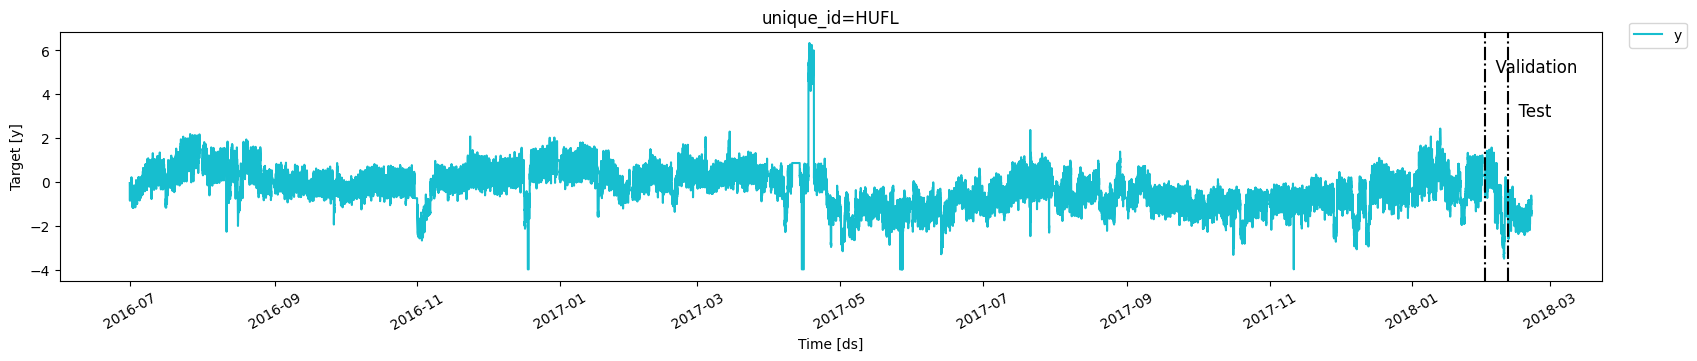

In [ ]:
u_id = 'HUFL'
fig = plot_series(Y_df, ids=[u_id])
ax = fig.axes[0]

x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values
x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

ax.axvline(x_val, color='black', linestyle='-.')
ax.axvline(x_test, color='black', linestyle='-.')
ax.text(x_val, 5, '  Validation', fontsize=12)
ax.text(x_test, 3, '  Test', fontsize=12)
fig

## 3. Hyperparameter selection and forecasting

The `AutoNHITS` class will automatically perform hyperparamter tunning using [Tune library](https://docs.ray.io/en/latest/tune/index.html), exploring a user-defined or default search space. Models are selected based on the error on a validation set and the best model is then stored and used during inference. 

The `AutoNHITS.default_config` attribute contains a suggested hyperparameter space. Here, we specify a different search space following the paper's hyperparameters. Notice that *1000 Stochastic Gradient Steps* are enough to achieve SoTA performance. Feel free to play around with this space.

In [ ]:
import logging

import torch
from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import DistributionLoss
from ray import tune

In [ ]:
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
torch.set_float32_matmul_precision('high')

In [ ]:
horizon = 96 # 24hrs = 4 * 15 min.

# Use your own config or AutoNHITS.default_config
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "random_seed": tune.randint(1, 10),
       "scaler_type": tune.choice(['robust']),
       "val_check_steps": tune.choice([100])
    }

:::{.callout-tip}
Refer to https://docs.ray.io/en/latest/tune/index.html for more information on the different space options, such as lists and continous intervals.m
:::

To instantiate `AutoNHITS` you need to define:

* `h`: forecasting horizon
* `loss`: training loss. Use the `DistributionLoss` to produce probabilistic forecasts.
* `config`: hyperparameter search space. If `None`, the `AutoNHITS` class will use a pre-defined suggested hyperparameter space.
* `num_samples`: number of configurations explored.

In [ ]:
models = [AutoNHITS(h=horizon,
                    loss=DistributionLoss(distribution='StudentT', level=[80, 90]), 
                    config=nhits_config,
                    num_samples=5)]

Fit the model by instantiating a `NeuralForecast` object with the following required parameters:

* `models`: a list of models.

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

In [ ]:
# Fit and predict
nf = NeuralForecast(models=models, freq='15min')

The `cross_validation` method allows you to simulate multiple historic forecasts, greatly simplifying pipelines by replacing for loops with `fit` and `predict` methods.

With time series data, cross validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The `cross_validation` method will use the validation set for hyperparameter selection, and will then produce the forecasts for the test set.

In [ ]:
%%capture
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

## 4. Visualization

Finally, we merge the forecasts with the `Y_df` dataset and plot the forecasts.

In [ ]:
Y_hat_df

,unique_id,ds,AutoNHITS,AutoNHITS-median,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90
502944,OT,2018-02-11 12:15:00,-1.033846,-1.036120,-1.136418,-1.107116,-0.958919,-0.921281
502945,OT,2018-02-11 12:30:00,-1.001433,-1.001392,-1.160503,-1.111777,-0.882919,-0.831176
502946,OT,2018-02-11 12:45:00,-0.937962,-0.939637,-1.136741,-1.070050,-0.807724,-0.752457
502947,OT,2018-02-11 13:00:00,-0.917211,-0.917466,-1.100279,-1.050083,-0.783510,-0.725839
502948,OT,2018-02-11 13:15:00,-0.876303,-0.872786,-1.134365,-1.057353,-0.695866,-0.637935
...,...,...,...,...,...,...,...,...
503035,OT,2018-02-12 11:00:00,-1.366006,-1.371263,-1.812504,-1.687056,-1.065438,-0.960703
503036,OT,2018-02-12 11:15:00,-1.292128,-1.298940,-1.857594,-1.703018,-0.915413,-0.659883
503037,OT,2018-02-12 11:30:00,-1.259905,-1.252504,-1.816049,-1.641870,-0.878118,-0.735540
503038,OT,2018-02-12 11:45:00,-1.175016,-1.182610,-1.714001,-1.532490,-0.820307,-0.705948


In [ ]:
Y_hat_df = Y_hat_df.reset_index(drop=True)
Y_hat_df = Y_hat_df[(Y_hat_df['unique_id']=='OT') & (Y_hat_df['cutoff']=='2018-02-11 12:00:00')]
Y_hat_df = Y_hat_df.drop(columns=['y','cutoff'])

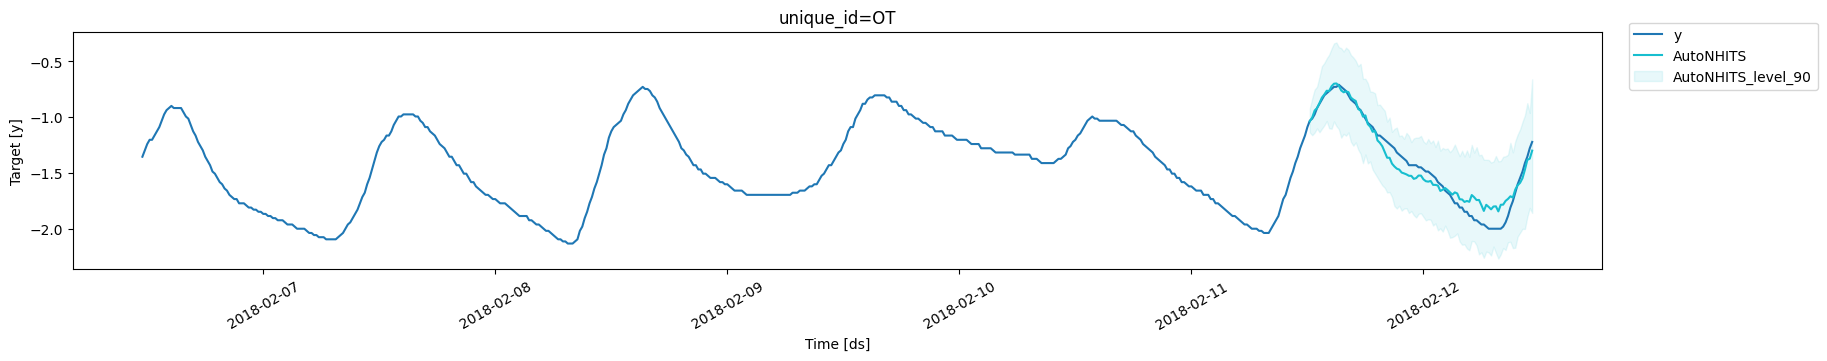

In [ ]:
plot_df = Y_df.merge(Y_hat_df, on=['unique_id','ds'], how='outer').tail(96*10+50+96*4).head(96*2+96*4)
plot_series(forecasts_df=plot_df.drop(columns='AutoNHITS').rename(columns={'AutoNHITS-median': 'AutoNHITS'}), level=[90])

## References

[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)